In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/Colab Notebooks/OOD New
%ls data/dbpedia

Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks/OOD New
DBPEDIA_test.csv  DBPEDIA_train.csv  DBPEDIA_val.csv


In [2]:
!pip install transformers &> /dev/null
!pip install datasets &> /dev/null

import numpy as np
import pandas as pd
import transformers
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torch import cuda
import re

from transformers import AutoTokenizer

import tqdm
from sklearn.metrics import f1_score, accuracy_score

import matplotlib.pyplot as plt

device = 'cuda' if cuda.is_available() else 'cpu'
torch.manual_seed(0)
np.random.seed(0)

In [3]:
import models_decoder
import models_baseline
import dbpedia_utils

In [4]:
# Dataset
DATA_DIR = 'data/dbpedia'
TOP_K = 4
MAX_LEN = 256

TRAIN_BATCH_SIZE = 32
TEST_BATCH_SIZE = 32
EPOCHS = 10
LEARNING_RATE = 1e-05

train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': TEST_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }


# Model
model_type = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_type, use_fast=False)
hidden_dim = 512
dropout = 0.
loss = torch.nn.MSELoss()
contrastive_loss_weight = -1
label_embedding_updating = 'none' # gradient/recompute/none
TOP_K = 4
device = device

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

In [5]:
train_df, test_df, val_df, train_withheld, label2index = dbpedia_utils.get_dataloaders(DATA_DIR, TOP_K, MAX_LEN, tokenizer)
train_loader = DataLoader(train_df, **train_params)
train_withheld_loader = DataLoader(train_withheld, **train_params)
test_loader = DataLoader(test_df, **test_params)

sorted_labels = sorted(list(label2index.items()), key= lambda x : x[1])
sorted_labels = [x[0] for x in sorted_labels]

In [6]:
decoder = models_decoder.DECODER_OOD(model_type,
                        hidden_dim,
                        loss,
                        dropout,
                        contrastive_loss_weight,
                        label_embedding_updating,
                        sorted_labels,
                        TOP_K,
                        device
                        ).to(device)

optimizer = torch.optim.Adam(decoder.get_optimizer_parameters(), lr = LEARNING_RATE)

Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Label embeddings initialized without gradients


/content/drive/My Drive/Colab Notebooks/OOD New/models_decoder.py:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.label_embeddings = torch.tensor(self.label_embeddings, requires_grad=False)


In [7]:
losses, total_loss, f1s = decoder.train_model(train_loader, optimizer, 1, test_loader)

  0%|          | 0/1 [00:00<?, ?epoch/s]

  0%|          | 0/6662 [00:00<?, ?batch/s]

  0%|          | 0/6662 [00:00<?, ?batch/s]

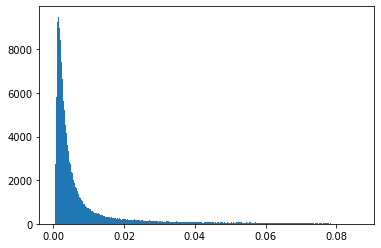

In [8]:
_, id_logits, _ = decoder.test_model(train_loader)
id_logits = np.asarray([x.cpu()[-1] for x in id_logits])
plt.hist(id_logits, bins='auto')
plt.show()

  0%|          | 0/869 [00:00<?, ?batch/s]

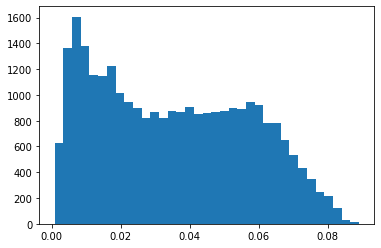

In [9]:
_, ood_logits, _ = decoder.test_model(train_withheld_loader)
ood_logits = np.asarray([x.cpu()[-1] for x in ood_logits])
plt.hist(ood_logits, bins='auto')
plt.show()